In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from sklearn.model_selection import KFold
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
import multiprocess
from sklearn.metrics import accuracy_score, classification_report



Create reproducible results

In [404]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)


In [405]:
num_processes = multiprocess.cpu_count()

print("Number of cpu : ", num_processes)
pool = multiprocess.Pool(processes=num_processes - 4)

Number of cpu :  8


In [406]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [407]:

def plot_graph(train_losses,losses,epochs,title):
    print(len(losses))
    print(len(train_losses))

    num_epochs = list(range(0, epochs))  
    print(len(num_epochs))
    # Plotting
    plt.plot(num_epochs, train_losses, label=' Training Loss ')
    plt.plot(num_epochs, losses, label=title+' Loss')

    plt.title('Training and '+title+' Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [408]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size,):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [409]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [410]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [411]:
def Padding(validation_losses_fold,train_losses_fold):
    max_epochs = max(map(len, validation_losses_fold))

    for validation_loss_arr in validation_losses_fold:
        while len(validation_loss_arr) < max_epochs:
            validation_loss_arr.append(validation_loss_arr[-1])

    for train_loss_arr in train_losses_fold:
      while len(train_loss_arr) < max_epochs:
            train_loss_arr.append(train_loss_arr[-1])

    print(len(validation_losses_fold))
    return validation_losses_fold,train_losses_fold

In [412]:
def Mean(validation_avg_loss_fold,train_losses_fold):
    max_epochs = max(map(len, validation_avg_loss_fold))
    validation_avg_loss = []
    train_avg_loss = []
    
    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(validation_avg_loss_fold)):
            temp_loss += validation_avg_loss_fold[j][i]
        validation_avg_loss.append(temp_loss)

    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(train_losses_fold)):
            temp_loss += train_losses_fold[j][i]
        train_avg_loss.append(temp_loss)
    
    return validation_avg_loss,train_avg_loss
    

    

In [413]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    # Initialize optimizer
    if (opt.__name__ == "RMSprop") or (opt.__name__ == "SGD"):
      optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    else:
      optimizer = opt(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    train_losses = []
    test_losses = []
    epoch_train_accuracy = []
    epoch_test_accuracy = []

    tolerance_stopper = ToleranceStopper(patience=40, min_delta=1e-5)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0


      # Set current loss and accuracy value for test
      test_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32).to(device)
        targets = data[:, [0]].to(torch.float32).to(device)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)
      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(epoch_train_loss)
      # Update accuracy
      for output, target in zip(outputs, targets):
        output = 0 if output.item() < 0.5 else 1
        if output == target.item():
          epoch_train_accuracy.append(1)
        else:
          epoch_train_accuracy.append(0)
      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32).to(device)
          targets = data[:, [0]].to(torch.float32).to(device)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_test_accuracy.append(1)
          else:
            epoch_test_accuracy.append(0)
        print(epoch_test_loss)
        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch+1,"test")
    return network


In [414]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


    tolerance_stopper = ToleranceStopper(patience=40, min_delta=1e-5)
    train_losses = []
    validaition_losses = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))

      avg_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(avg_train_loss) 
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    '''if(retrain == True):
      plot_graph(train_losses,validaition_losses,epoch,"validation")'''
    return avg_valid_loss,avg_train_loss,validaition_losses,train_losses


In [415]:
def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay):
    
    validation_avg_loss_fold = 0
    train_avg_loss_fold = 0
    validation_losses_fold = []
    train_losses_fold = []
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss,train_loss,validation_losses,train_losses = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        train_avg_loss_fold += train_loss
        validation_losses_fold.append(validation_losses)
        train_losses_fold.append(train_losses)

        num_iterations += 1


    #validation average over all folds
    validation_avg_loss_fold /= num_iterations
    
    validation_losses_fold,train_losses_fold = Padding(validation_losses_fold,train_losses_fold)

    validation_losses_mean, train_losses_mean = Mean(validation_losses_fold, train_losses_fold)
    
    #plot_graph(train_losses_mean,validation_losses_mean,len(validation_losses),"validation") TODO ESEGUIRE ALLA FINE


    return (validation_avg_loss_fold,train_avg_loss_fold,current_config)

function that executes the folds for each combination of parameters

In [416]:
def dogridsearch(dataset_train_part,params_grid,output_size,input_size):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"]) 


    configurations = []

    for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')

        (validation_avg_loss_fold,train_avg_loss_fold,current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                        ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size)


        configurations.append((validation_avg_loss_fold, train_avg_loss_fold,current_config))
        
        actual_it += 1


    #best 
    for conf_val in configurations:
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[2]
                best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    return best_params

test the created model and plot training/test error

In [417]:
def train_test_model(dataset_train_part,dataset_test_part,best_params):
    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[9], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[9], sampler=test_subsampler)

    best_net = fit_model(learning_rate=best_params[2],epochs=best_params[3],hidden_size=best_params[5],input_size=17,loss_function=best_params[4],
                        momentum=best_params[6],opt=best_params[7],output_size=1,trainloader=trainloader,weight_decay=best_params[8],testloader=testloader)   
    return best_net

In [418]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}
    

dataset_train_part = read_ds(TR_PATH_1)
dataset_test_part = read_ds(TS_PATH_1)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%


Early stopping: 208
Early stopping: 429
Early stopping: 127
5


monk 1:
Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0022038360655424185, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)

In [419]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.019156468184559194, 0.010460588727022801, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.26378562435921693
Starting epoch 2
0.22436451153070838
Starting epoch 3
0.1922309961066478
Starting epoch 4
0.19368687422118253
Starting epoch 5
0.19783236095423085
Starting epoch 6
0.17379214946413413
Starting epoch 7
0.17082608124689647
Starting epoch 8
0.16140107315085414
Starting epoch 9
0.15007766358407768
Starting epoch 10
0.13071149363639523
Starting epoch 11
0.11176514068049276
Starting epoch 12
0.10499551329822107
Starting epoch 13
0.0952765936844689
Starting epoch 14
0.09300903753427081
Starting epoch 15
0.08938033581674702
Starting epoch 16
0.08834286668435973
Starting epoch 17
0.08734417107000438
Starting epoch 18
0.08684611144794703
Starting epoch 19
0.08615891967875305
Starting epoch 20
0.08583227171442963
Starting epoch 21
0.08578741698416976
Starting epoch 22
0.08505175443025548
Starting epoch 23
0.08465360388099388
Starting epoch 24
0.08423585080405853
Starting epoch 25
0.08384850009342362
Starting epoch 26
0.08329484035062638
Starting epoch 27
0.082

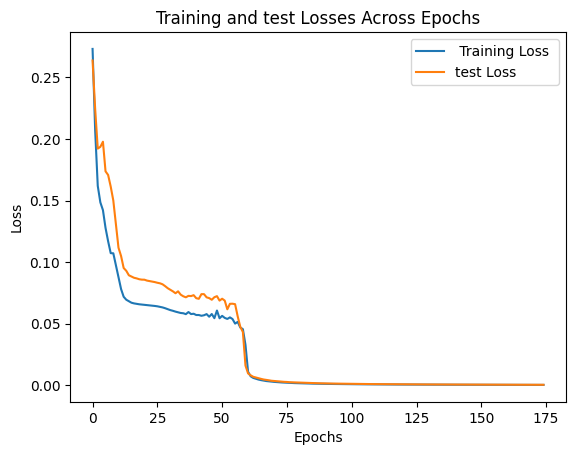

In [420]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



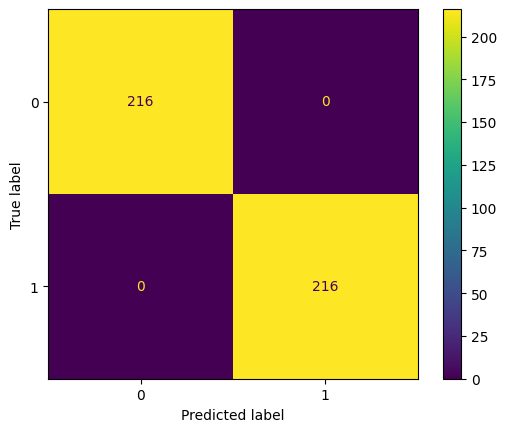

------------------------------------------------------------------------------------------------------


In [421]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 2

In [422]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}
    

dataset_train_part = read_ds(TR_PATH_2)
dataset_test_part = read_ds(TS_PATH_2)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)
        




Actual iter 0.0%
Early stopping: 97
Early stopping: 254
Early stopping: 105
Early stopping: 97
Early stopping: 90
5


In [423]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0004608255448755198, 0.0007109626302547466, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Starting epoch 1
0.25330840092566276
Starting epoch 2
0.22532115987053625
Starting epoch 3
0.3053196809358067
Starting epoch 4
0.21587643981048907
Starting epoch 5
0.17687560407513822
Starting epoch 6
0.18763781171637
Starting epoch 7
0.12355718829807032
Starting epoch 8
0.12687605981180375
Starting epoch 9
0.05338951735326124
Starting epoch 10
0.03366663965344843
Starting epoch 11
0.016379331719319993
Starting epoch 12
0.010357788760167616
Starting epoch 13
0.007663062262441532
Starting epoch 14
0.006359142488185575
Starting epoch 15
0.005668292408935721
Starting epoch 16
0.004981576824421709
Starting epoch 17
0.004449424407977387
Starting epoch 18
0.0042025122498604035
Starting epoch 19
0.0038302626061421405
Starting epoch 20
0.0035501841430905863
Starting epoch 21
0.0032654418031328263
Starting epoch 22
0.003062983282520522
Starting epoch 23
0.002864054488411596
Starting epoch 24
0.0027400765313898403
Starting epoch 25
0.002565713548257783
Starting epoch 26
0.002464725313378343
Star

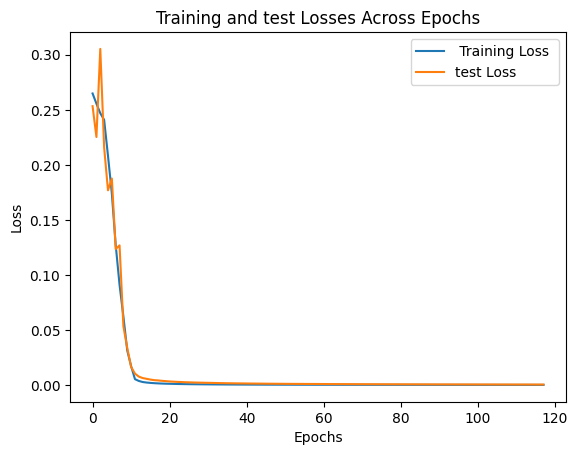

In [424]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



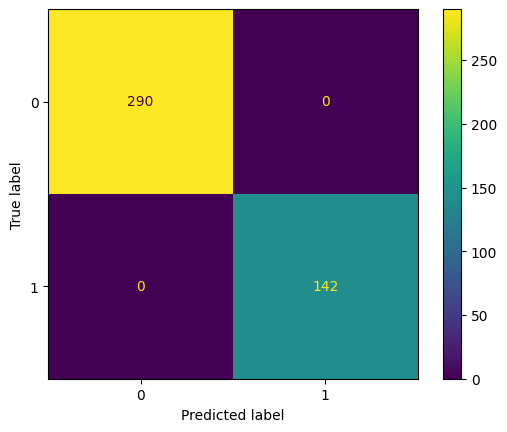

------------------------------------------------------------------------------------------------------


In [425]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 3

In [426]:
input_size = 17  
output_size = 1
params_grid_u = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0.0001,0.02,0.001,0.1,0.2],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}


params_grid = {
    "hidden_size": [4,5],
    "learning_rate": [0.1, 0.05, 0.2],
    "batch_size": [16,32],
    "weight_decay": [0.01,0.1,0.2],
    "momentum": [0.4, 0.01, 0.05, 0.1],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}

dataset_train_part = read_ds(TR_PATH_3)
dataset_test_part = read_ds(TS_PATH_3)

dataset = dataset_train_part
best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size)


Actual iter 0.0%
Early stopping: 136
Early stopping: 156
Early stopping: 271
Early stopping: 147
Early stopping: 183
5
Actual iter 0.6944444444444444%
Early stopping: 234
Early stopping: 164
Early stopping: 182
Early stopping: 146
Early stopping: 158
5
Actual iter 1.3888888888888888%
Early stopping: 201
Early stopping: 171
Early stopping: 194
Early stopping: 209
Early stopping: 180
5
Actual iter 2.083333333333333%
Early stopping: 203
Early stopping: 176
Early stopping: 199
Early stopping: 158
Early stopping: 147
5
Actual iter 2.7777777777777777%
Early stopping: 147
Early stopping: 51
Early stopping: 265
Early stopping: 40
Early stopping: 260
5
Actual iter 3.4722222222222223%
Early stopping: 308
Early stopping: 49
Early stopping: 58
Early stopping: 48
Early stopping: 184
5
Actual iter 4.166666666666666%
Early stopping: 49
Early stopping: 50
Early stopping: 72
Early stopping: 138
Early stopping: 54
5
Actual iter 4.861111111111112%
Early stopping: 41
Early stopping: 45
Early stopping: 274

In [427]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.2 
Best batch size: 32 
Best weight decay: 0.01 
Best momentum: 0.05
(0.07683771699666977, 0.3306015259403067, 0.2, 600, MSELoss(), 4, 0.05, <class 'torch.optim.sgd.SGD'>, 0.01, 32)


Starting epoch 1
0.24850747541145043
Starting epoch 2
0.24211950324199819
Starting epoch 3
0.23713411335591916
Starting epoch 4
0.23314439698501868
Starting epoch 5
0.22979185426676715
Starting epoch 6
0.2267970073002356
Starting epoch 7
0.22399605369126355
Starting epoch 8
0.22128406939683137
Starting epoch 9
0.2186274947943511
Starting epoch 10
0.2158314905784748
Starting epoch 11
0.2130078579540606
Starting epoch 12
0.210081336122972
Starting epoch 13
0.2067770207369769
Starting epoch 14
0.20341248037638487
Starting epoch 15
0.19981702168782553
Starting epoch 16
0.19622343557852287
Starting epoch 17
0.19245730119722862
Starting epoch 18
0.188263401389122
Starting epoch 19
0.1841459423303604
Starting epoch 20
0.17950562084162677
Starting epoch 21
0.17509101276044492
Starting epoch 22
0.17050179894323703
Starting epoch 23
0.16598309576511383
Starting epoch 24
0.16155832674768236
Starting epoch 25
0.15657988632166828
Starting epoch 26
0.15158978601296744
Starting epoch 27
0.14675349162

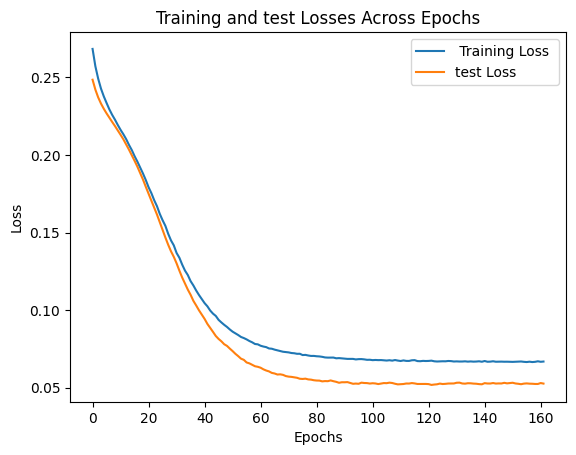

In [428]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params)  

accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



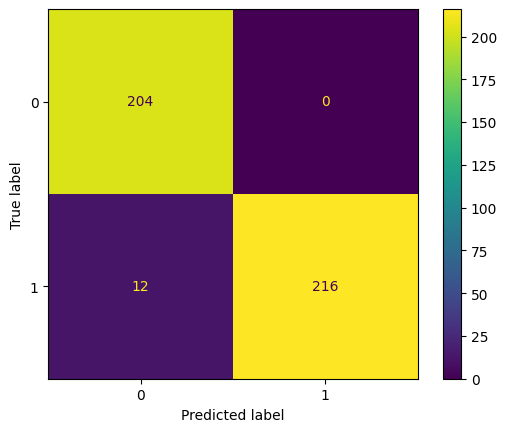

------------------------------------------------------------------------------------------------------


In [429]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
